```
Copyright 2019 Augusto Cunha and Axelle Pochet

Permission is hereby granted, free of charge, to any person obtaining a copy of this code and 
associated documentation files, to deal in the code without restriction, 
including without limitation the rights to use, copy, modify, merge, publish, distribute, 
sublicense, and/or sell copies of the code, and to permit persons to whom the code is 
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or 
substantial portions of the code.

THE CODE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT 
NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, 
DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, 
OUT OF OR IN CONNECTION WITH THE CODE OR THE USE OR OTHER DEALINGS IN THE CODE.

__license__ = "MIT"
__author__ = "Augusto Cunha, Axelle Pochet"
__email__ = "acunha@tecgraf.puc-rio.br, axelle@tecgraf.puc-rio.br"
__credits__ = ["Augusto Cunha", "Axelle Pochet", "Helio Lopes", "Marcelo Gattass"]
```

# SFD-CNN-TL: Train final model and save

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['KERAS_BACKEND'] = 'tensorflow'

import sys
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
import classifier
import imageio
import metrics
import keras.utils.vis_utils as graph # new keras version
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.filters import gaussian
from skimage import measure
from skimage import exposure
from sklearn.feature_extraction import image
from sklearn import svm
from sklearn.externals import joblib
from sklearn.utils import shuffle
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image, ImageDraw
from keras.models import Sequential, Model, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D # new keras version
from keras.utils import np_utils
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(1337)

Using TensorFlow backend.


In [2]:
# adjust some settings for matplotlib for notebooks with black background
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 9
rcParams['text.color'] = 'white'
rcParams['axes.labelcolor'] = 'white'
rcParams['xtick.color'] = 'white'
rcParams['ytick.color'] = 'white'

In [5]:
# Enable interactive plots
#%matplotlib notebook

## Workflow
- Use our provided Syntectic dataset network weights
- Interpret one slice of the real data volume that will be classified
- Generate slice fault mask
- Train and save each analyzed method

## Define a seismic name

In [3]:
seismic_name = "gsb"

## Format csv file

In [4]:
# Gaussian smoothing with default std 1.5
# https://stackoverflow.com/a/45020378
def myGaussSmooth( data, std=1.5):
    return gaussian(data,sigma=std,truncate=2)

In [5]:
#Clipping 
def clip(data,min=-6000,max=6000):
    data[data>max] = max
    data[data<min] = min
    return data

In [6]:
# Normalizes values of a matrix between -1 and 1
def myNormalization(data):
    max_val = np.max(data)
    min_val = np.min(data)
    
    return  2 * (data[:,:] - min_val) / (max_val - min_val) - 1

In [7]:
sections = []

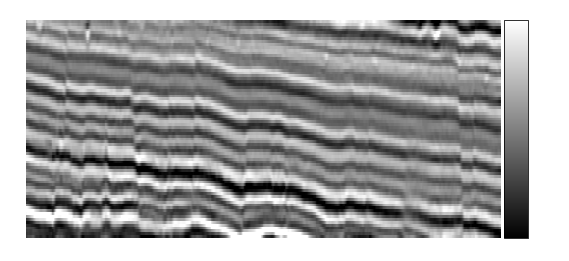

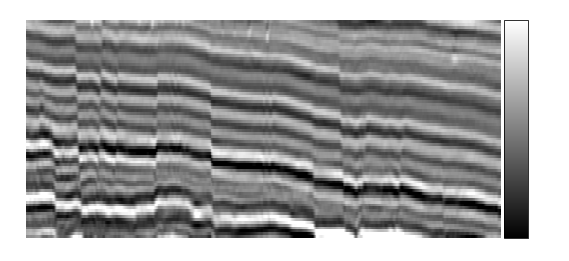

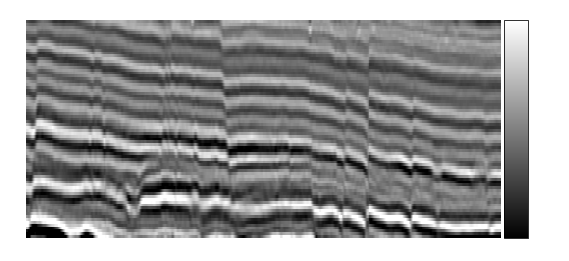

In [21]:
for i in [2600,2800,3000]:
    # Set configurations for format subvolume
    data_file = 'data/gsb_crl_'+str(i)+'.csv'
    min_inl = 1565 #1565
    max_inl = 2531 #2531
    step_inl = 2
    min_crl = i #2568
    max_crl = i #3568
    step_crl = 2
    min_z = 1000
    max_z = 1300
    step_z = 4

    # Define sections type
    types=['inline','crossline','z-slice','section_coords']
    section_type = 'crossline'

    output_dir = 'data/formatted/'+seismic_name+'/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir) 

    # Read and format files
    raw_data = np.genfromtxt(data_file, delimiter='\t')

    if(section_type == "inline"):
        nb_crosslines = (max_crl - min_crl) / step_crl + 1

    if(section_type == "crossline"):
        nb_crosslines = (max_inl - min_inl) / step_inl + 1

    nb_sections = raw_data.shape[0]/nb_crosslines

    for k in range(int(nb_sections)):
        # Output name
        if(section_type == "inline"):
            inl_nb = int(min_inl + k);
            name = 'inl'+str(inl_nb)+'_sc_formatted.csv'
        if(section_type == "crossline"):
            crl_nb = int(min_crl + k);
            name = 'crl'+str(crl_nb)+'_sc_formatted.csv'

        # Read
        section = raw_data[k*int(nb_crosslines) : (k+1)*int(nb_crosslines), : ]
        section = np.transpose(section)
        section = np.fliplr(section)

        # Smooth
        section = myGaussSmooth(section, std=1.0)

        # Clip
        #section = clip(section)

        perc = np.percentile(section, [1,99])
        section = exposure.rescale_intensity(section, in_range=(perc[0], perc[1]), out_range=(-1,1))

        # Normalize between -1 and 1 
        #section = myNormalization(section)

        # Write
        #np.savetxt(output_dir + name, section, delimiter=" ")

        # Append
        sections.append(section)

        # Visualize
        plt.figure(figsize=(9,4))
        plt.title('Section ' + str(i))
        plt.axis('off')
        ax = plt.gca()
        im = plt.imshow(section, cmap="gray", aspect='auto')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

## Create colormap

In [4]:
# get colormap
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))
# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
color_array[255] = [1., 0., 0., 0.5]

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='faults',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

In [5]:
# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
color_array[255] = [0., 0., 1., 0.5]

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='masks',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

## Set min values and steps

In [6]:
min_inl = 1565
step_inl = 2
min_crl = 2568
step_crl = 2
min_z = 1000
step_z = 4

## Generate mask image from fault points file
Our faults was exported from opendTect as ordered point set, witch points pair is one fault

In [7]:
sections = []

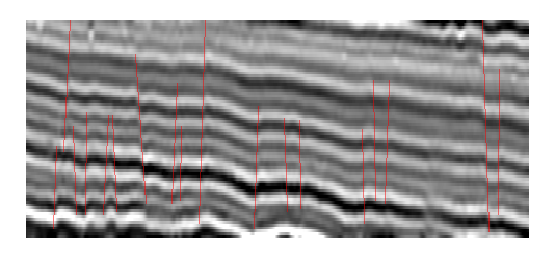

In [8]:
section_file = 'output/sections_regions/gsb/crl2600_sc_formatted_region_(1565.1000)(2531.1300).csv'
my_data = np.genfromtxt(section_file, delimiter=' ')
sections.append(my_data)
mask_file = 'data/gsb_crl_2600_mask.ascii'
mask_data = np.genfromtxt(mask_file, delimiter='\t')
lines_pair_points = []

for i in range(0,mask_data.shape[0]):
    lines_pair_points.append(int(mask_data[i,6]-min_inl)/step_inl)
    lines_pair_points.append(int((mask_data[i,2]-min_z)/step_z))

im = Image.new('L', (my_data.shape[1], my_data.shape[0]), 0)

draw = ImageDraw.Draw(im)
for i in range(0,len(lines_pair_points),4):
    draw.line((lines_pair_points[i],lines_pair_points[i+1],lines_pair_points[i+2],lines_pair_points[i+3]), fill=1, width=1)
del draw

mask_img = np.array(im)
mask_img = np.fliplr(mask_img)

 # Visualize
plt.figure(figsize=(9,4))
plt.title('Section 2600')
plt.axis('off')
plt.imshow(my_data, cmap="gray", aspect='auto')
plt.imshow(mask_img, cmap="faults", aspect='auto')
#plt.imsave('mask.png', mask_img, cmap="gray")

mask_img_2600 = mask_img

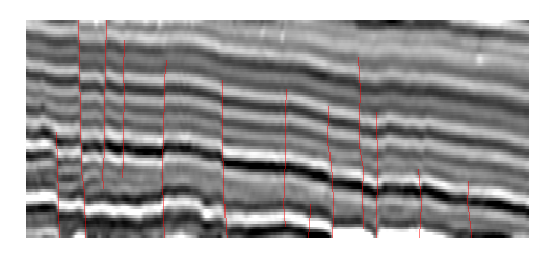

In [15]:
section_file = 'output/sections_regions/gsb/crl2800_sc_formatted_region_(1565.1000)(2531.1300).csv'
my_data = np.genfromtxt(section_file, delimiter=' ')
sections.append(my_data)
mask_file = 'mask_haibin_thin.png'
mask_img = cv2.imread(mask_file)
mask_img = mask_img[:,:,1]
mask_img = mask_img/255
lines_pair_points = []

 # Visualize
plt.figure(figsize=(9,4))
plt.title('Section 2800')
plt.axis('off')
plt.imshow(my_data, cmap="gray", aspect='auto')
plt.imshow(mask_img, cmap="faults", aspect='auto')
#plt.imsave('mask.png', mask_img, cmap="gray")

mask_img_2800 = mask_img

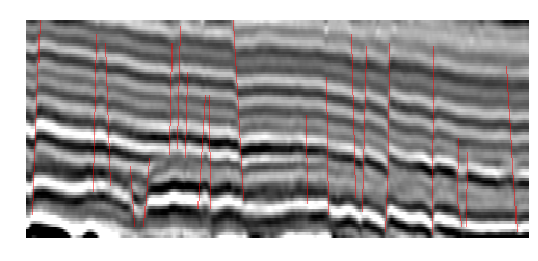

In [10]:
section_file = 'output/sections_regions/gsb/crl3000_sc_formatted_region_(1565.1000)(2531.1300).csv'
my_data = np.genfromtxt(section_file, delimiter=' ')
sections.append(my_data)
mask_file = 'data/gsb_crl_3000_mask.ascii'
mask_data = np.genfromtxt(mask_file, delimiter='\t')
lines_pair_points = []

for i in range(0,mask_data.shape[0]):
    lines_pair_points.append((mask_data[i,6]-min_inl)/step_inl)
    lines_pair_points.append(int((mask_data[i,2]-min_z)/step_z))

im = Image.new('L', (my_data.shape[1], my_data.shape[0]), 0)

draw = ImageDraw.Draw(im)
for i in range(0,len(lines_pair_points),4):
    draw.line((lines_pair_points[i],lines_pair_points[i+1],lines_pair_points[i+2],lines_pair_points[i+3]), fill=1, width=1)
del draw

mask_img = np.array(im)
mask_img = np.fliplr(mask_img)

 # Visualize
plt.figure(figsize=(9,4))
plt.title('Section 3000')
plt.axis('off')
plt.imshow(my_data, cmap="gray", aspect='auto')
plt.imshow(mask_img, cmap="faults", aspect='auto')
#plt.imsave('mask.png', mask_img, cmap="gray")

mask_img_3000 = mask_img

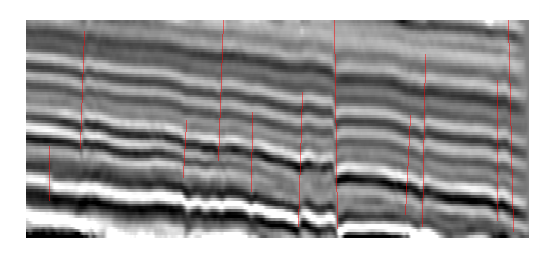

In [11]:
section_file = 'output/sections_regions/gsb/inl1791_sc_formatted_region_(2568.1000)(3568.1300).csv'
my_data = np.genfromtxt(section_file, delimiter=' ')
sections.append(my_data)
mask_file = 'data/gsb_inl_1791_mask.ascii'
mask_data = np.genfromtxt(mask_file, delimiter='\t')
lines_pair_points = []

for i in range(0,mask_data.shape[0]):
    lines_pair_points.append(int(mask_data[i,7]-min_crl)/step_crl-3)
    lines_pair_points.append(int(mask_data[i,2]-min_z)/step_z)

im = Image.new('L', (my_data.shape[1], my_data.shape[0]), 0)

draw = ImageDraw.Draw(im)
for i in range(0,len(lines_pair_points),4):
    draw.line((lines_pair_points[i],lines_pair_points[i+1],lines_pair_points[i+2],lines_pair_points[i+3]), fill=1, width=1)
del draw

mask_img = np.array(im)
mask_img = np.fliplr(mask_img)

 # Visualize
plt.figure(figsize=(9,4))
plt.title('Section 1796')
plt.axis('off')
plt.imshow(my_data, cmap="gray", aspect='auto')
plt.imshow(mask_img, cmap="faults", aspect='auto')
#plt.imsave('mask.png', mask_img, cmap="gray")

mask_img_1796 = mask_img

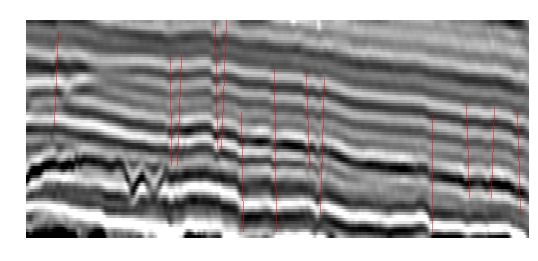

In [12]:
section_file = 'output/sections_regions/gsb/inl2011_sc_formatted_region_(2568.1000)(3568.1300).csv'
my_data = np.genfromtxt(section_file, delimiter=' ')
sections.append(my_data)
mask_file = 'data/gsb_inl_2011_mask.ascii'
mask_data = np.genfromtxt(mask_file, delimiter='\t')
lines_pair_points = []

for i in range(0,mask_data.shape[0]):
    lines_pair_points.append(int(mask_data[i,7]-min_crl)/step_crl-3)
    lines_pair_points.append(int(mask_data[i,2]-min_z)/step_z)

im = Image.new('L', (my_data.shape[1], my_data.shape[0]), 0)

draw = ImageDraw.Draw(im)
for i in range(0,len(lines_pair_points),4):
    draw.line((lines_pair_points[i],lines_pair_points[i+1],lines_pair_points[i+2],lines_pair_points[i+3]), fill=1, width=1)
del draw

mask_img = np.array(im)
mask_img = np.fliplr(mask_img)

 # Visualize
plt.figure(figsize=(9,4))
plt.title('Section 2011')
plt.axis('off')
plt.imshow(my_data, cmap="gray", aspect='auto')
plt.imshow(mask_img, cmap="faults", aspect='auto')
#plt.imsave('mask.png', mask_img, cmap="gray")

mask_img_2011 = mask_img

## Generate patches from real slice

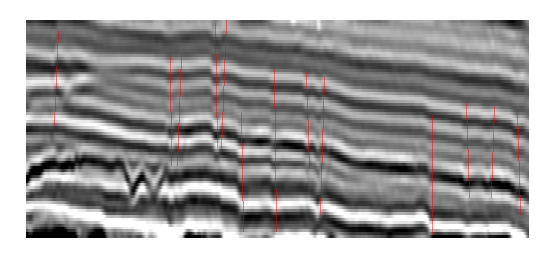

In [51]:
# Our method patch size
mask_size = 13
resize_size = 45
pixel_step = 1
imageChannels = 1

patches_fault = []
patches_fault_name = []
patches_non_fault = []
patches_non_fault_name = []
patches = []
patches_name = []

masks = [mask_img_2600,mask_img_2800,mask_img_3000,mask_img_1796,mask_img_2011]

#rezise_top, rezise_bottom, rezise_left, rezise_right = [int(mask_size/2)]*4
rezise_top, rezise_bottom, rezise_left, rezise_right = [0]*4

#for sec_idx in range(len(sections)):
for sec_idx in [4]:
    #reflected_section = cv2.copyMakeBorder(sections[sec_idx], rezise_top, rezise_bottom, rezise_left, rezise_right, cv2.BORDER_REFLECT)
    #reflected_mask = cv2.copyMakeBorder(masks[sec_idx], rezise_top, rezise_bottom, rezise_left, rezise_right, cv2.BORDER_CONSTANT,value=[0,0,0])
    reflected_section = sections[sec_idx]
    reflected_mask = masks[sec_idx]
    
    plt.figure(figsize=(9,4))
    plt.title("model "+str(sec_idx))
    plt.axis('off')
    plt.imshow(reflected_section, cmap="gray", aspect='auto')
    plt.imshow(reflected_mask, cmap="faults", aspect='auto')

    #patches_img = image.extract_patches_2d(reflected_section, (mask_size, mask_size))
    #patches_mask = image.extract_patches_2d(reflected_mask, (mask_size, mask_size))
    patches_img , patches_img_names = classifier.processPatches(reflected_section,  mask_size, pixel_step, resize_size, imageChannels)
    patches_mask , patches_mask_names = classifier.processPatches(reflected_mask,  mask_size, pixel_step, resize_size, imageChannels)
    patches = patches_img
    patches_name = patches_img_names
    
    for i in range(0, len(patches_mask)):
        if (patches_mask[i] == 0).sum() == patches_mask[i].size:
            patch = patches_img[i]
            patches_non_fault.append(patch)
            patches_non_fault_name.append(patches_img_names[i])
        elif (patches_mask[i][int(resize_size/2)-1:int(resize_size/2)+2,int(resize_size/2)-1:int(resize_size/2)+2]==0).sum() < 9:
        #elif patches_mask[i][int(resize_size/2),int(resize_size/2)] == 1:
            patch = patches_img[i]
            patches_fault.append(patch)
            patches_fault_name.append(patches_img_names[i])

## Reconstruct image from patches

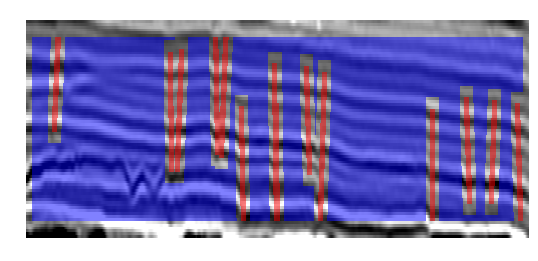

In [52]:
section_file = 'output/sections_regions/gsb/inl2011_sc_formatted_region_(2568.1000)(3568.1300).csv'
my_data = np.genfromtxt(section_file, delimiter=' ')

mask = np.zeros(my_data.shape)
fault = np.zeros(my_data.shape)
for patch_name in (patches_fault_name):
    #print(patch_name)
    x = int(patch_name.split("_")[2])-rezise_left
    y = int(patch_name.split("_")[3].split(".")[0])-rezise_left
    fault[x,y] = 1
for patch_name in (patches_non_fault_name):
    #print(patch_name)
    x = int(patch_name.split("_")[2])-rezise_left
    y = int(patch_name.split("_")[3].split(".")[0])-rezise_left
    mask[x,y] = 1

plt.figure(figsize=(9,4))
plt.title("model")
plt.axis('off')
plt.imshow(my_data, cmap="gray", aspect='auto')
plt.imshow(mask, cmap="masks", aspect='auto')
plt.imshow(fault, cmap="faults", aspect='auto')

## Classify and get metrics for each analyzed method

In [53]:
print(len(patches_fault))
print(len(patches_non_fault))

2828
23588


In [54]:
# pass input as numpy arrays
X = np.array(patches_fault+patches_non_fault)
#X = np.array(patches)
X = X.reshape( X.shape[0], 45, 45, 1)
#X = X.reshape( X.shape[0], 32, 32, 1)
X = X.astype( 'float32' )

# sparsify labels
patches = np.concatenate([np.full(len(patches_fault),1),np.full(len(patches_non_fault),0)])
Y = np_utils.to_categorical(patches.tolist(), 2)

#Shuffle dataset
shuffle(X, Y, random_state=1337)

[array([[[[ 0.21102983],
          [ 0.21086474],
          [ 0.21059434],
          ...,
          [ 0.4611713 ],
          [ 0.47749522],
          [ 0.48250768]],
 
         [[ 0.18921793],
          [ 0.18904456],
          [ 0.18873988],
          ...,
          [ 0.43244904],
          [ 0.4489261 ],
          [ 0.45397526]],
 
         [[ 0.11480117],
          [ 0.11458805],
          [ 0.11413503],
          ...,
          [ 0.33602318],
          [ 0.35329765],
          [ 0.358555  ]],
 
         ...,
 
         [[-0.7553873 ],
          [-0.7558618 ],
          [-0.7575053 ],
          ...,
          [-0.02318183],
          [ 0.06260564],
          [ 0.08856116]],
 
         [[-0.98368293],
          [-0.9839682 ],
          [-0.9850323 ],
          ...,
          [-0.20447993],
          [-0.11285596],
          [-0.08520321]],
 
         [[-1.        ],
          [-1.        ],
          [-1.        ],
          ...,
          [-0.25787094],
          [-0.16415185],
    

In [55]:
print(X.shape)
print(Y.shape)

(26416, 45, 45, 1)
(26416, 2)


## VGG

In [56]:
 def metrics_VGG(x_test, y_test, numberOfClasses=2):
    ################# load base model #################
    modelJsonPath = 'base_model/model.json'
    modelWeightsPath = 'base_model/model.h5'

    jsonFile = open(modelJsonPath, 'r')
    loadedModelJson = jsonFile.read()
    jsonFile.close()
    base_model = model_from_json(loadedModelJson)
    base_model.load_weights(modelWeightsPath)
        
    base_model.compile( loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'] )
    classesPredictionList = base_model.predict_classes(x_test, verbose=0) # 0 or 1
    classesProbaPredictionList = base_model.predict_proba(x_test) # probability
    sensitivity, specificity, accuracy, precision, recall, F1_score, auc = metrics.generate_metrics(classesPredictionList,classesProbaPredictionList,y_test,verbose=False)
    
    print("Accuracy: {:.4f}".format(accuracy))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))
    print("F1 Score: {:.4f}".format(F1_score))
    print("AUC: {:.4f}".format(auc))
    
    return classesPredictionList, classesProbaPredictionList

In [57]:
classesPredictionListResult, classesProbaPredictionListResult = metrics_VGG(X,Y)

Accuracy: 0.8675
Sensitivity: 0.0304
Specificity: 0.9679
F1 Score: 0.0468
AUC: 0.5972


[Text(1,0,'0%'), Text(1,0,'50%'), Text(1,0,'100%')]

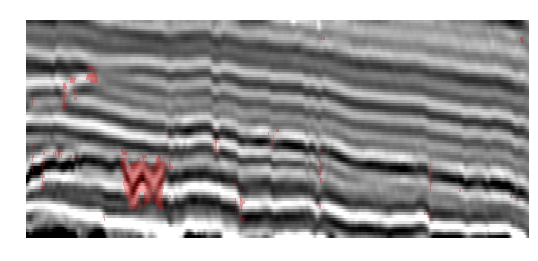

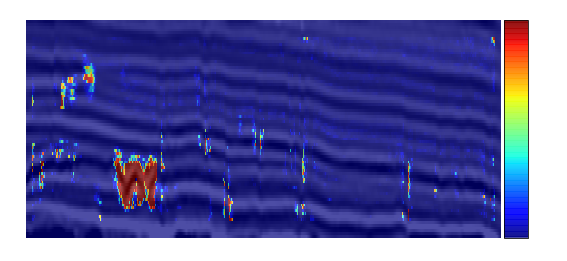

In [58]:
section_file = 'output/sections_regions/gsb/inl2011_sc_formatted_region_(2568.1000)(3568.1300).csv'
my_data = np.genfromtxt(section_file, delimiter=' ')

mask = np.zeros(my_data.shape)
for patch_name, classification in zip((patches_fault_name+patches_non_fault_name),classesPredictionListResult):
    #print(patch_name)
    x = int(patch_name.split("_")[2])-rezise_left
    y = int(patch_name.split("_")[3].split(".")[0])-rezise_left
    mask[x,y] = classification

plt.figure(figsize=(9,4))
plt.title("model Classification")
plt.axis('off')
ax = plt.gca()
plt.imshow(my_data, cmap="gray", aspect='auto')
#plt.imshow(mask, cmap="faults", aspect='auto')
im = plt.imshow(mask, cmap="faults", aspect='auto', alpha=0.7)

mask = np.zeros(my_data.shape)
for patch_name, classification in zip((patches_fault_name+patches_non_fault_name),classesProbaPredictionListResult):
    #print(patch_name)
    x = int(patch_name.split("_")[2])-rezise_left
    y = int(patch_name.split("_")[3].split(".")[0])-rezise_left
    mask[x,y] = classification[1]

plt.figure(figsize=(9,4))
plt.title("model Heatmap")
plt.axis('off')
ax = plt.gca()
plt.imshow(my_data, cmap="gray", aspect='auto')
#plt.imshow(mask, cmap="faults", aspect='auto')
im = plt.imshow(mask, cmap="jet", aspect='auto', alpha=0.7)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
v = [0, 0.5,1]
cbar = plt.colorbar(im, cax=cax, ticks=v)
cbar.ax.set_yticklabels(['0%', '50%','100%']) 

## FFT

In [59]:
 def metrics_FFT(x_test, y_test, numberOfClasses=2):
    ################# load base model #################
    modelJsonPath = 'models/gsbFFT_haibin_thin.json'
    modelWeightsPath = 'models/gsbFFT_haibin_thin.h5'

    jsonFile = open(modelJsonPath, 'r')
    loadedModelJson = jsonFile.read()
    jsonFile.close()
    base_model = model_from_json(loadedModelJson)
    base_model.load_weights(modelWeightsPath)
        
    base_model.compile( loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'] )
    classesPredictionList = base_model.predict_classes(x_test, verbose=0) # 0 or 1
    classesProbaPredictionList = base_model.predict_proba(x_test) # probability
    sensitivity, specificity, accuracy, precision, recall, F1_score, auc = metrics.generate_metrics(classesPredictionList,classesProbaPredictionList,y_test,verbose=False)
    
    print("Accuracy: {:.4f}".format(accuracy))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))
    print("F1 Score: {:.4f}".format(F1_score))
    print("AUC: {:.4f}".format(auc))
    
    return classesPredictionList, classesProbaPredictionList

In [60]:
classesPredictionListResult, classesProbaPredictionListResult = metrics_FFT(X,Y)

Accuracy: 0.8809
Sensitivity: 0.2054
Specificity: 0.9619
F1 Score: 0.2698
AUC: 0.7677


[Text(1,0,'0%'), Text(1,0,'50%'), Text(1,0,'100%')]

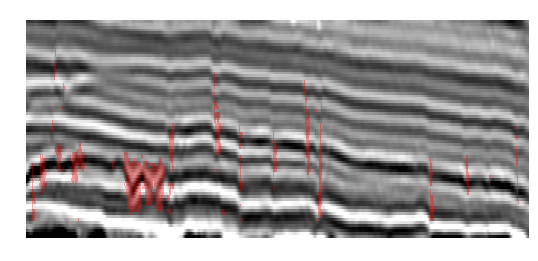

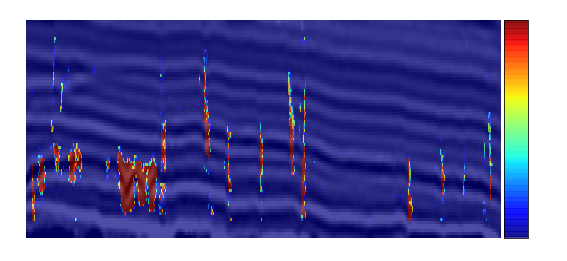

In [61]:
section_file = 'output/sections_regions/gsb/inl2011_sc_formatted_region_(2568.1000)(3568.1300).csv'
my_data = np.genfromtxt(section_file, delimiter=' ')

mask = np.zeros(my_data.shape)
for patch_name, classification in zip((patches_fault_name+patches_non_fault_name),classesPredictionListResult):
    #print(patch_name)
    x = int(patch_name.split("_")[2])-rezise_left
    y = int(patch_name.split("_")[3].split(".")[0])-rezise_left
    mask[x,y] = classification

plt.figure(figsize=(9,4))
plt.title("model Classification")
plt.axis('off')
ax = plt.gca()
plt.imshow(my_data, cmap="gray", aspect='auto')
#plt.imshow(mask, cmap="faults", aspect='auto')
im = plt.imshow(mask, cmap="faults", aspect='auto', alpha=0.7)

mask = np.zeros(my_data.shape)
for patch_name, classification in zip((patches_fault_name+patches_non_fault_name),classesProbaPredictionListResult):
    #print(patch_name)
    x = int(patch_name.split("_")[2])-rezise_left
    y = int(patch_name.split("_")[3].split(".")[0])-rezise_left
    mask[x,y] = classification[1]

plt.figure(figsize=(9,4))
plt.title("model")
plt.axis('off')
ax = plt.gca()
plt.imshow(my_data, cmap="gray", aspect='auto')
#plt.imshow(mask, cmap="faults", aspect='auto')
im = plt.imshow(mask, cmap="jet", aspect='auto', alpha=0.7)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
v = [0, 0.5,1]
cbar = plt.colorbar(im, cax=cax, ticks=v)
cbar.ax.set_yticklabels(['0%', '50%','100%']) 

## MLP

In [62]:
def metrics_MLP(x_test, y_test, numberOfClasses=2, MLP1=100, MLP2=200, numberOfEpochs=20):
    ################# load base model #################
    modelJsonPath = 'models/gsbMLP_haibin_thin.json'
    modelWeightsPath = 'models/gsbMLP_haibin_thin.h5'

    jsonFile = open(modelJsonPath, 'r')
    loadedModelJson = jsonFile.read()
    jsonFile.close()
    base_model = model_from_json(loadedModelJson)
    base_model.load_weights(modelWeightsPath)
        
    base_model.compile( loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'] )
    classesPredictionList = base_model.predict_classes(x_test, verbose=0) # 0 or 1
    classesProbaPredictionList = base_model.predict_proba(x_test) # probability
    sensitivity, specificity, accuracy, precision, recall, F1_score, auc = metrics.generate_metrics(classesPredictionList,classesProbaPredictionList,y_test,verbose=False)
    
    print("Accuracy: {:.4f}".format(accuracy))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))
    print("F1 Score: {:.4f}".format(F1_score))
    print("AUC: {:.4f}".format(auc))
    
    return classesPredictionList, classesProbaPredictionList

In [63]:
classesPredictionListResult, classesProbaPredictionListResult = metrics_MLP(X,Y)

Accuracy: 0.8229
Sensitivity: 0.2751
Specificity: 0.8885
F1 Score: 0.2496
AUC: 0.6582


[Text(1,0,'0%'), Text(1,0,'50%'), Text(1,0,'100%')]

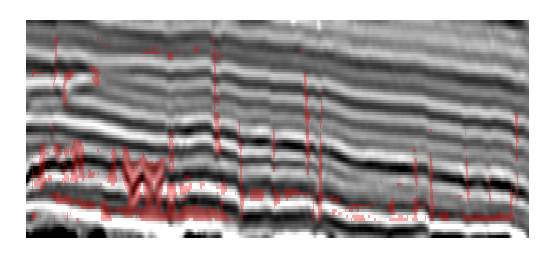

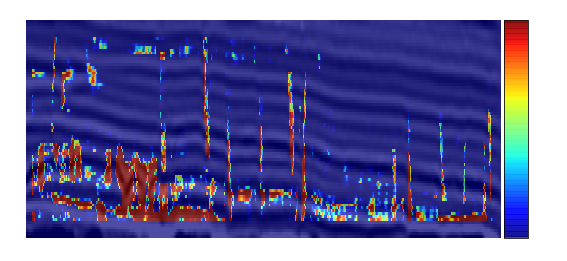

In [64]:
section_file = 'output/sections_regions/gsb/inl2011_sc_formatted_region_(2568.1000)(3568.1300).csv'
my_data = np.genfromtxt(section_file, delimiter=' ')

mask = np.zeros(my_data.shape)
for patch_name, classification in zip((patches_fault_name+patches_non_fault_name),classesPredictionListResult):
    #print(patch_name)
    x = int(patch_name.split("_")[2])-rezise_left
    y = int(patch_name.split("_")[3].split(".")[0])-rezise_left
    mask[x,y] = classification

plt.figure(figsize=(9,4))
plt.title("model Classification")
plt.axis('off')
ax = plt.gca()
plt.imshow(my_data, cmap="gray", aspect='auto')
#plt.imshow(mask, cmap="faults", aspect='auto')
im = plt.imshow(mask, cmap="faults", aspect='auto', alpha=0.7)

mask = np.zeros(my_data.shape)
for patch_name, classification in zip((patches_fault_name+patches_non_fault_name),classesProbaPredictionListResult):
    #print(patch_name)
    x = int(patch_name.split("_")[2])-rezise_left
    y = int(patch_name.split("_")[3].split(".")[0])-rezise_left
    mask[x,y] = classification[1]

plt.figure(figsize=(9,4))
plt.title("model")
plt.axis('off')
ax = plt.gca()
plt.imshow(my_data, cmap="gray", aspect='auto')
#plt.imshow(mask, cmap="faults", aspect='auto')
im = plt.imshow(mask, cmap="jet", aspect='auto', alpha=0.7)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
v = [0, 0.5,1]
cbar = plt.colorbar(im, cax=cax, ticks=v)
cbar.ax.set_yticklabels(['0%', '50%','100%']) 

## SVM

In [65]:
def metrics_SVM(x_test, y_test, numberOfClasses=2, c=10, K='rbf', save=False):
    ################# load base model #################
    #print( "Importing base model..." )
    modelJsonPath = 'base_model/model.json'
    modelWeightsPath = 'base_model/model.h5'
    svmModelPath = 'models/gsbSVM_haibin_thin.pkl'

    jsonFile = open(modelJsonPath, 'r')
    loadedModelJson = jsonFile.read()
    jsonFile.close()
    base_model = model_from_json(loadedModelJson)
    base_model.load_weights(modelWeightsPath)
    clf = joblib.load(svmModelPath)
    
    # remove last layers
    base_model = Sequential(base_model.layers[:-7])
    
    features = base_model.predict(x_test)
    classesPredictionList = clf.predict(features) # 0 or 1
    classesProbaPredictionList = clf.predict_proba(features) # probability
    sensitivity, specificity, accuracy, precision, recall, F1_score, auc = metrics.generate_metrics(classesPredictionList,classesProbaPredictionList,y_test,verbose=False)
        
    print("Accuracy: {:.4f}".format(accuracy))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))
    print("F1 Score: {:.4f}".format(F1_score))
    print("AUC: {:.4f}".format(auc))
    
    return classesPredictionList, classesProbaPredictionList

In [66]:
classesPredictionListResult, classesProbaPredictionListResult = metrics_SVM(X,Y)

Accuracy: 0.8725
Sensitivity: 0.1627
Specificity: 0.9576
F1 Score: 0.2146
AUC: 0.7140


[Text(1,0,'0%'), Text(1,0,'50%'), Text(1,0,'100%')]

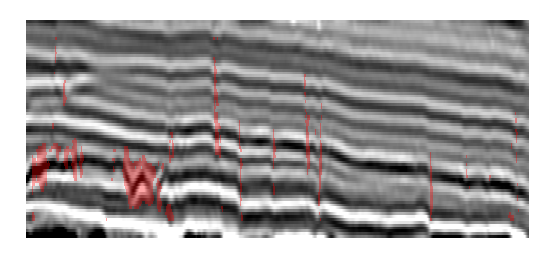

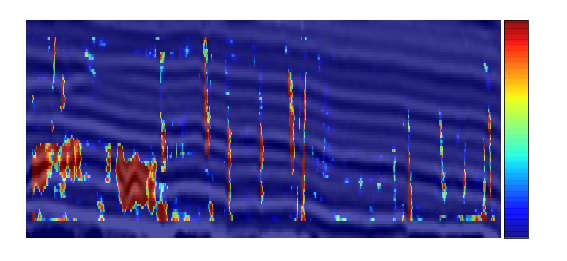

In [67]:
section_file = 'output/sections_regions/gsb/inl2011_sc_formatted_region_(2568.1000)(3568.1300).csv'
my_data = np.genfromtxt(section_file, delimiter=' ')

mask = np.zeros(my_data.shape)
for patch_name, classification in zip((patches_fault_name+patches_non_fault_name),classesPredictionListResult):
    #print(patch_name)
    x = int(patch_name.split("_")[2])-rezise_left
    y = int(patch_name.split("_")[3].split(".")[0])-rezise_left
    mask[x,y] = classification

plt.figure(figsize=(9,4))
plt.title("model Classification")
plt.axis('off')
ax = plt.gca()
plt.imshow(my_data, cmap="gray", aspect='auto')
#plt.imshow(mask, cmap="faults", aspect='auto')
im = plt.imshow(mask, cmap="faults", aspect='auto', alpha=0.7)

mask = np.zeros(my_data.shape)
for patch_name, classification in zip((patches_fault_name+patches_non_fault_name),classesProbaPredictionListResult):
    #print(patch_name)
    x = int(patch_name.split("_")[2])-rezise_left
    y = int(patch_name.split("_")[3].split(".")[0])-rezise_left
    mask[x,y] = classification[1]

plt.figure(figsize=(9,4))
plt.title("model")
plt.axis('off')
ax = plt.gca()
plt.imshow(my_data, cmap="gray", aspect='auto')
#plt.imshow(mask, cmap="faults", aspect='auto')
im = plt.imshow(mask, cmap="jet", aspect='auto', alpha=0.7)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
v = [0, 0.5,1]
cbar = plt.colorbar(im, cax=cax, ticks=v)
cbar.ax.set_yticklabels(['0%', '50%','100%']) 